# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

*Признаки*

-  DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передачPower — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

*Целевой признак*

- Price — цена (евро)

*Примечания:*


- Для оценки качества моделей применить метрику RMSE.
- Самостоятельно освоить библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del:
del features_train

## Подготовка данных

### Выгрузка необходимых библиотек. Знакомство с данными.

In [ ]:
# Произведем установку необходимых библиотек.
# Ниже указано для каких объектов это сделано.


!pip install category_encoders
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np

# Настройка, чтобы текст в ячейке отображался весь.
pd.set_option('display.max_colwidth', None)
# Настроим 2 знака после точки в float и разделение запятой тысячные до запятой.
pd.set_option('display.float_format', '{:,.2f}'.format)
# Уберем сообщения об ошибке -цепного присваивания.
pd.options.mode.chained_assignment = None


# Выгрузим модели для обучения.
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor as dtr
from lightgbm import LGBMRegressor
import lightgbm as lgb
#!pip install catboost
from catboost import CatBoostRegressor

# для создания конструктора модели+кодировка.
from sklearn.pipeline import Pipeline, FeatureUnion

# Выгрузим показатели эффективности модели.
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy import stats as st


# импортируем библиотеки для кодирования и подготовки данных, а так же поиска лучших гиперпараметров.
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score,RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
#!pip install category_encoders
from category_encoders.cat_boost import CatBoostEncoder



# Для построения графиков

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
plt. style. use('dark_background')

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3


# Для вывода результатов.
from pprint import pprint
from IPython.display import display

In [ ]:
# Прочитаем файл данных и укажем колонки,
# которые подходят для построения модели. Так же уже можно указать тип данных для колонки 'reg_year'.
file_list=['datasets/autos.csv']

# создадим лист с названиями колонок. В нижнем регистре колонки, которые останутся в датафрейме после прочтения файла.
col_name=['DateCrawled', 'price', 'vehicle_type', 'reg_year', 'gearbox', 'power', 'model', 'kilometer', 'RegistrationMonth', 'fuel_type', 'brand',
       'repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen']
try:
  dataframe = pd.read_csv(file_list[0],header=0,names=col_name, usecols=[n for n in col_name if  n.islower()],dtype={'reg_year':'int'})
except:
  dataframe = pd.read_csv('https://code.s3.yandex.net/'+file_list[0],header=0,names=col_name, usecols=[n for n in col_name if  n. islower()], dtype={'reg_year':'int'})
df=dataframe.copy(deep=True)

In [ ]:
# Посмотрим на данные.

df. head(10)

,price,vehicle_type,reg_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN


In [ ]:
# Выведем описание данных.

display (df.describe (include='all'))
df. info()

,price,vehicle_type,reg_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
count,"354,369.00",316879,"354,369.00",334536,"354,369.00",334664,"354,369.00",321474,354369,283215
unique,NaN,8,NaN,2,NaN,250,NaN,7,40,2
top,NaN,sedan,NaN,manual,NaN,golf,NaN,petrol,volkswagen,no
freq,NaN,91457,NaN,268251,NaN,29232,NaN,216352,77013,247161
mean,"4,416.66",NaN,"2,004.23",NaN,110.09,NaN,"128,211.17",NaN,NaN,NaN
std,"4,514.16",NaN,90.23,NaN,189.85,NaN,"37,905.34",NaN,NaN,NaN
min,0.00,NaN,"1,000.00",NaN,0.00,NaN,"5,000.00",NaN,NaN,NaN
25%,"1,050.00",NaN,"1,999.00",NaN,69.00,NaN,"125,000.00",NaN,NaN,NaN
50%,"2,700.00",NaN,"2,003.00",NaN,105.00,NaN,"150,000.00",NaN,NaN,NaN
75%,"6,400.00",NaN,"2,008.00",NaN,143.00,NaN,"150,000.00",NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         354369 non-null  int64 
 1   vehicle_type  316879 non-null  object
 2   reg_year      354369 non-null  int64 
 3   gearbox       334536 non-null  object
 4   power         354369 non-null  int64 
 5   model         334664 non-null  object
 6   kilometer     354369 non-null  int64 
 7   fuel_type     321474 non-null  object
 8   brand         354369 non-null  object
 9   repaired      283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


#### Вывод


При первичном просмотре датафрейма было решено оставить только колонки необходимые для дальнейшего обучения моделей.

Колонка 'NumberOfPicture' - имела только 0 значения и точно не является весомым признаком. Также убраны колонки 'DateCrawled','DateCreated','LastSeen','PostalCode' не являющиеся признаками, влияющими на цену машины де-факто, но при своём присутствии маскируют наличие дубликатов по остальным признакам.

Признак 'reg_year' (год регистрации машины) -дискретный и поэтому сразу приведён к типу 'integer'.


### Работа с пропусками в данных.

In [ ]:
# Выведем среднее количество пропусков в колонках.
# С фильтром >0.

na_values=df.isna(). mean()
na_values=na_values [na_values>0]
na_values

vehicle_type   0.11
gearbox        0.06
model          0.06
fuel_type      0.09
repaired       0.20
dtype: float64

In [ ]:
# Удалим строки данных, где отсутствуют по всем 5 колонкам.

df=df.dropna(subset=['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired'],axis=0, how='all')
print(f' Удалено строк с отсутствием данных по всем 5 колонкам:\n\n {dataframe.price.shape[0]-df.price.shape[0]}\n\n')
print (df. info())

 Удалено строк с отсутствием данных по всем 5 колонкам:

 2237


<class 'pandas.core.frame.DataFrame'>
Int64Index: 352132 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         352132 non-null  int64 
 1   vehicle_type  316879 non-null  object
 2   reg_year      352132 non-null  int64 
 3   gearbox       334536 non-null  object
 4   power         352132 non-null  int64 
 5   model         334664 non-null  object
 6   kilometer     352132 non-null  int64 
 7   fuel_type     321474 non-null  object
 8   brand         352132 non-null  object
 9   repaired      283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.6+ MB
None


<div class="alert alert-block alert-success"; style="border-left: 6px solid green">
<b>Успех ✔️</b>
       
Классное решение, такие объекты действительно не имеет смысла "спасать"
    
</div>


Оставшиеся пропущенные значения
в датафрейме в долях:

vehicle_type   0.10
gearbox        0.05
model          0.05
fuel_type      0.09
repaired       0.20
dtype: float64 



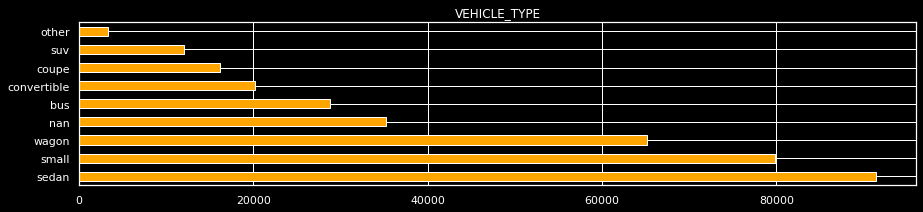

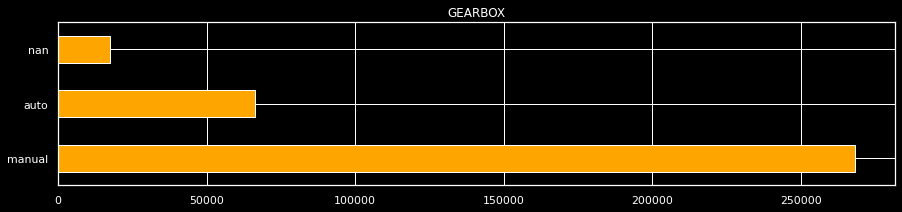

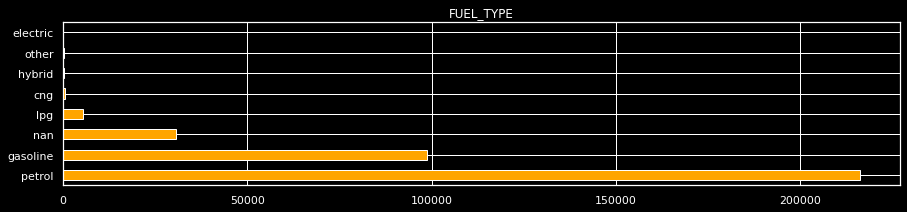

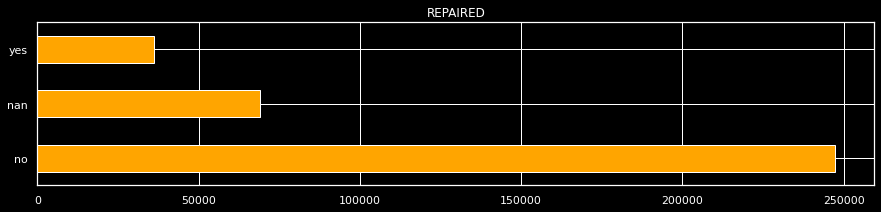

In [ ]:
# Посмотрим на оставшиеся пропуски. Построим графики.

print ('Оставшиеся пропущенные значения\nв датафрейме в долях:\n')
print (df.isna().mean()[df.isna().mean()>0],'\n')
na_values_nomodel=na_values[na_values>0].drop('model', axis=0)
for name in na_values_nomodel.index:
  df[name].value_counts(dropna=False).plot(kind='barh',color='orange'). set(title=name.upper())
  plt.show()

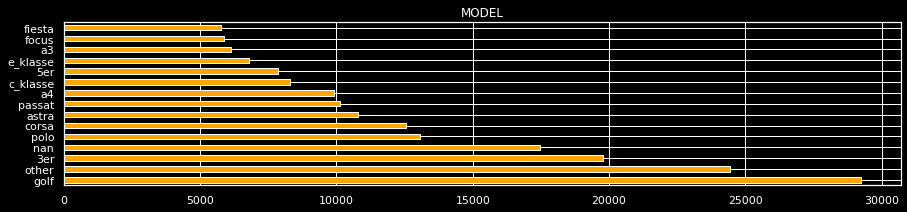

In [ ]:
# Посмотрим на распределение моделей машин в датафрейме.

df['model'].value_counts(dropna=False).head(15).plot(kind='barh',color='orange'). set(title='MODEL')
plt. show()

Оставшиеся пропуски в долях: 0.01


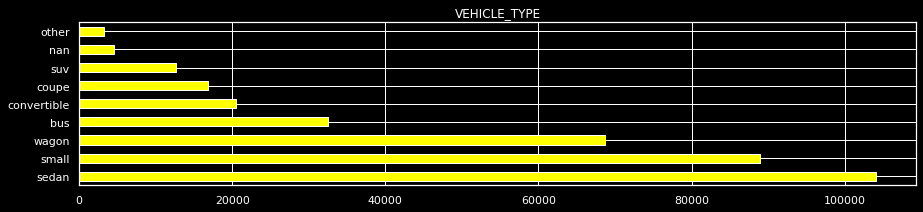

In [ ]:
# Заполним отсутствующие данные по типу кузова по аналогии с такими же моделями машин модой.

df. loc[df['vehicle_type'].isna(),'vehicle_type']=df.groupby(['brand','model'], sort=False)['vehicle_type'].apply(lambda x: x.fillna(x.mode().iloc[0]))
print ('Оставшиеся пропуски в долях:',round(df. vehicle_type.isna().mean(),2))
df['vehicle_type'].value_counts(dropna=False).plot(kind='barh',color='yellow'). set(title='VEHICLE_TYPE')
plt. show()

Оставшиеся пропуски в долях: 0.01


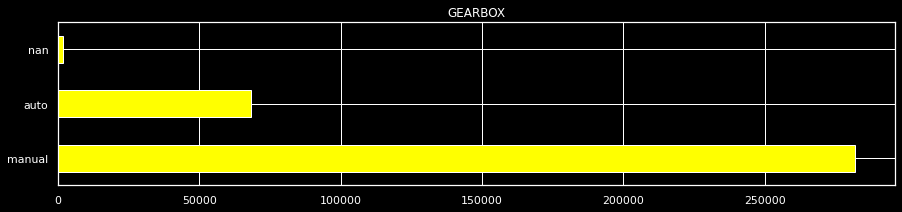

In [ ]:
# Заполним отсутствующие данные по типу коробки передач по аналогии с такими же моделями машин модой.

df. loc[df['gearbox'].isna(),'gearbox']=df.groupby(['brand','model'], sort=False)['gearbox'].apply(lambda x: x.fillna(x.mode().iloc[0]))
print ('Оставшиеся пропуски в долях:', round (df. gearbox.isna(). mean(),2))
df['gearbox'].value_counts(dropna=False).plot(kind='barh',color='yellow'). set(title='GEARBOX')
plt. show()

Оставшиеся пропуски в долях: 0.01


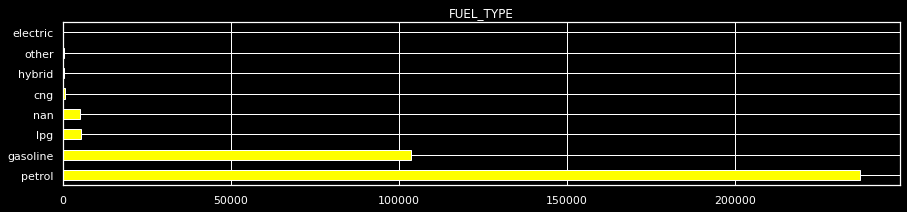

In [ ]:
# Заполним отсутствующие данные по типу топлива по аналогии с такими же моделями машин модой.

df. loc[df['fuel_type'].isna(),'fuel_type']=df.groupby(['brand','model'], sort=False)['fuel_type'].apply(lambda x: x.fillna(x.mode().iloc[0]))
print ('Оставшиеся пропуски в долях:', round (df. fuel_type.isna().mean(),2))
df['fuel_type'].value_counts(dropna=False).plot(kind='barh',color='yellow'). set(title='FUEL_TYPE')
plt. show()

In [ ]:
# Проверим, что осталось.

df.isna(). mean()

price          0.00
vehicle_type   0.01
reg_year       0.00
gearbox        0.01
power          0.00
model          0.05
kilometer      0.00
fuel_type      0.01
brand          0.00
repaired       0.20
dtype: float64

In [ ]:
# Заполним оставшиеся пропуски.


df. fillna({'repaired':'no',
            'vehicle_type':'other',
            'fuel_type':'petrol',
            'gearbox':'manual',
            'model':'noinfo'},inplace=True)

#### Вывод

В данном пункте была проведена работа по заполнению и удалению пропусков.
При первичном рассмотрении, самая большая доля пропусков была в признаке 'repaired'. Возможно это связано с желанием выставить машину подороже.

Шаги:

1. Проведено удаление строк, где обнаружено отсутствие данных по всем 5 признакам одномоментно.

2. Оставшиеся пропуски по колонкам fuel_type, vehicle_type, gearbox заполнены модой по группировке с колонками brand, model.

3. Оставшиеся пропуски по колонкам заполнили следующим образом:
* fuel_type - наиболее частым значением 'benzine'.
* vehicle_type - значением 'other'. Не видим смысла дублировать смысловую нагрузку названия типа кузова, для не определившихся собственников.
* gearbox - наиболее частым значением 'manual'.
* repaired - наиболее частым значением 'no'.
* model - создана категория 'noinfo'. В данном случае решено не увеличивать искуственно и без того огромную категорию 'other'.

### Удаление выбросов из данных.

<Figure size 1080x288 with 0 Axes>

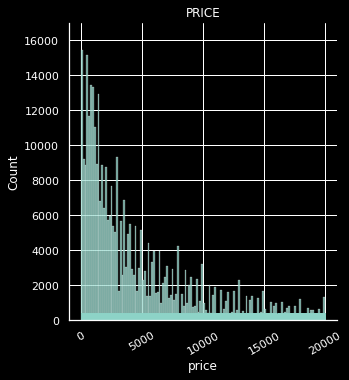

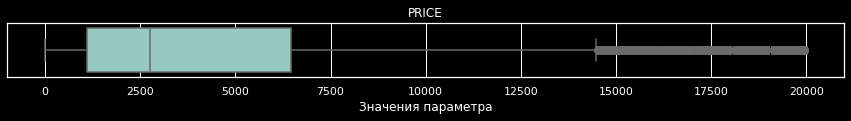

<Figure size 1080x288 with 0 Axes>

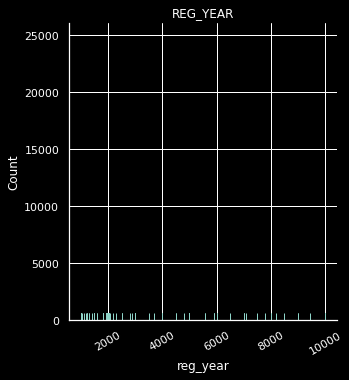

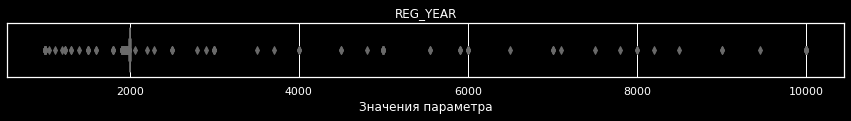

<Figure size 1080x288 with 0 Axes>

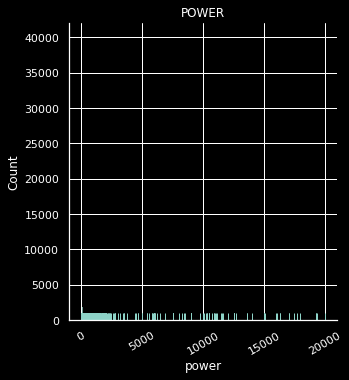

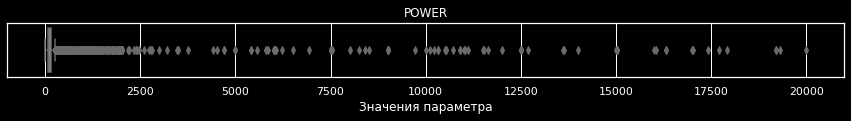

<Figure size 1080x288 with 0 Axes>

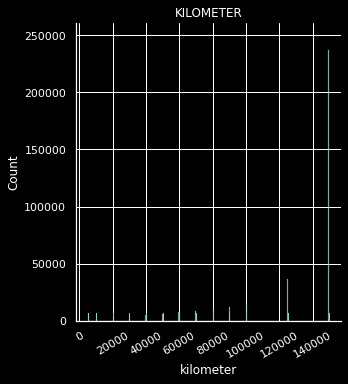

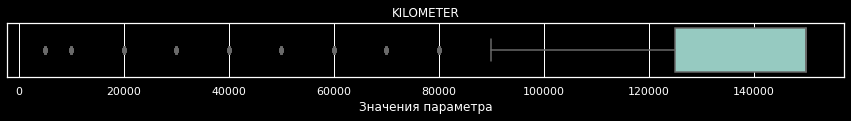

In [ ]:
# построим гистограммы для визуализации данных.


numb_value=['price','reg_year', 'power','kilometer']
categ_value=['vehicle_type', 'gearbox','model', 'fuel_type', 'brand', 'repaired']

for i in numb_value:
  plt. figure(figsize=(15, 4))
  sns. displot(data = df, x = df[i], rug=True).set(title=i.upper())
  plt. title(i.upper())
  plt. xticks(rotation=30)
  plt. show()
  plt. figure(figsize=(15, 1))
  sns. boxplot(data = df, x = df[i],orient='h').set(title=i.upper())
  plt. xlabel('Значения параметра')
  plt. show ()

In [ ]:
# Создадим копию дата фрейма до удаления выбросов.

old_df=df.copy(deep=True)

In [ ]:
# Создадим класс для создания объектов данных с тщательным изучением распределения данных в хвостах.
# bop - противовыбросовый превентор.
class Bop:
   def __init__(self,frame, full_frame=df):
     self. frame=frame
     self. full_frame=full_frame
   def tail_print (self):
     '''Функция принимает колонки с суммарной концентрацией металлов и
     выводит значения нижнего и верхнего квантиля, а также указывает значения
     размаха усов.
     '''
     q1=np.quantile(self.frame,.25)
     q3=np.quantile(self.frame,.75)
     iqr=q3-q1
     left_whiskers=q1-1.5*iqr
     right_whiskers=q3+1.5*iqr
     print (f'Q1 = {q1:.2f} \nQ3 = {q3:.2f} \nLeft_whiskers = {left_whiskers:.2f} \nRight_whiskers = {right_whiskers:.2f} \nMimimum= {self.frame.min():.2f} \nMaximum= {self.frame.max():.2f}')
   def tail_view (self,name,mode='min'):
     '''Функция выводит график распределения выбросов до верхнего
     и нижнего квантиля.
     '''
     if mode=='min':
       minimum=self.frame.min()
       filter= self. frame[(self.frame>=minimum)&(self.frame<=np.quantile(self.frame,.25))]
       plt. figure(figsize=(10, 5))
       sns.displot(filter, rug=True).set(title=name.upper())
       plt. show()
     else:
       maximum=self.frame.max()
       filter= self. frame[(self.frame<=maximum)&(self.frame>=np.quantile(self.frame,.75))]
       sns.displot(filter, rug=True).set(title=name.upper())
       plt. show()
     print ('Mean of frame:',round(self.frame.mean()))
     print ('Median of frame:', round(self.frame. median()))

Q1 = 1100.00 
Q3 = 6450.00 
Left_whiskers = -6925.00 
Right_whiskers = 14475.00 
Mimimum= 0.00 
Maximum= 20000.00


<Figure size 720x360 with 0 Axes>

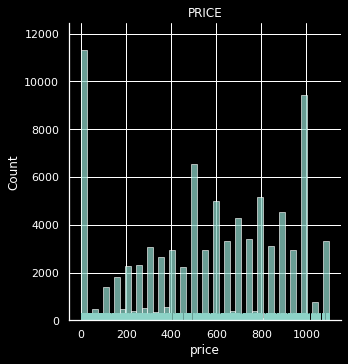

Mean of frame: 4438
Median of frame: 2750


In [ ]:
# Проведём анализ распределения цены автомобилей.

price_1=Bop(df.price)
price_1.tail_print ()
price_1.tail_view('PRICE')

In [ ]:
# Заполним медианным значением цены равные 0 евро с группировкой по моделям автомобилей.

print (f'Количество данных в колонке Price с 0 значением:{df.loc[df.price == 0].shape[0]}')
df.loc[(df['price'] == 0),'price']=df.groupby(['model'], sort=False)['price'].transform(lambda x: round (x.median(),0))

Количество данных в колонке Price с 0 значением:10039


Q1 = 1200.00 
Q3 = 6490.00 
Left_whiskers = -6735.00 
Right_whiskers = 14425.00 
Mimimum= 1.00 
Maximum= 20000.00


<Figure size 720x360 with 0 Axes>

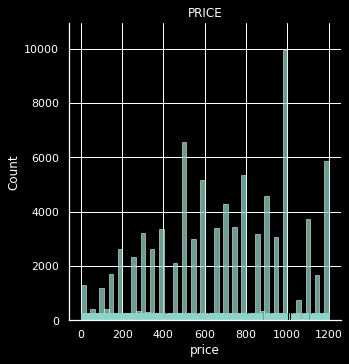

Mean of frame: 4513
Median of frame: 2800


In [ ]:
# Посмотрим на оставшиеся данные по цене меньше q1.

price_2=Bop(df.price)
price_2. tail_print ()
price_2.tail_view('PRICE')

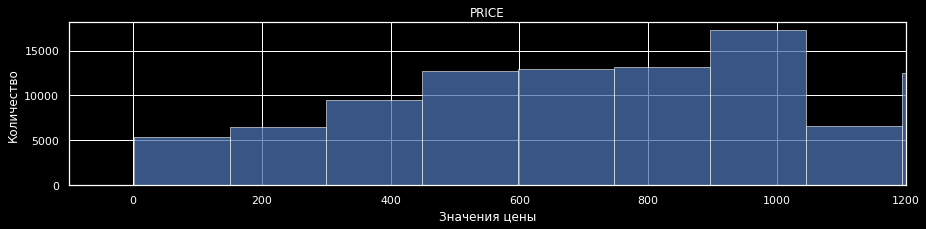

In [ ]:
# Посмотрим на распределение цены меньше q1.


sns. histplot(df['price']).set(title='PRICE')
plt.xlim(-100,1200)
plt. xlabel('Значения цены')
plt. ylabel('Количество')
plt. show ()

In [ ]:
# Посмотрим на описание данные при цене <200 евро.


df.loc[(df.price<200),'price'].value_counts(sort=False,bins=30)

(0.801, 7.6]      1116
(7.6, 14.2]         99
(14.2, 20.8]        72
(20.8, 27.4]        30
(27.4, 34.0]        53
(34.0, 40.6]        65
(40.6, 47.2]        17
(47.2, 53.8]       315
(53.8, 60.4]        79
(60.4, 67.0]        18
(67.0, 73.6]        66
(73.6, 80.2]       193
(80.2, 86.8]        10
(86.8, 93.4]        39
(93.4, 100.0]     1096
(100.0, 106.6]       8
(106.6, 113.2]      49
(113.2, 119.8]      12
(119.8, 126.4]     287
(126.4, 133.0]     106
(133.0, 139.6]      12
(139.6, 146.2]      52
(146.2, 152.8]    1621
(152.8, 159.4]      17
(159.4, 166.0]      67
(166.0, 172.6]      88
(172.6, 179.2]      70
(179.2, 185.8]     261
(185.8, 192.4]     115
(192.4, 199.0]     291
Name: price, dtype: int64

In [ ]:
# Удалим данные по цене <147 евро.

df=df.loc[df.price>=147]
df. info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348338 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         348338 non-null  int64 
 1   vehicle_type  348338 non-null  object
 2   reg_year      348338 non-null  int64 
 3   gearbox       348338 non-null  object
 4   power         348338 non-null  int64 
 5   model         348338 non-null  object
 6   kilometer     348338 non-null  int64 
 7   fuel_type     348338 non-null  object
 8   brand         348338 non-null  object
 9   repaired      348338 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.2+ MB


Q1 = 1999.00 
Q3 = 2008.00 
Left_whiskers = 1985.50 
Right_whiskers = 2021.50 
Mimimum= 1000.00 
Maximum= 9999.00


<Figure size 720x360 with 0 Axes>

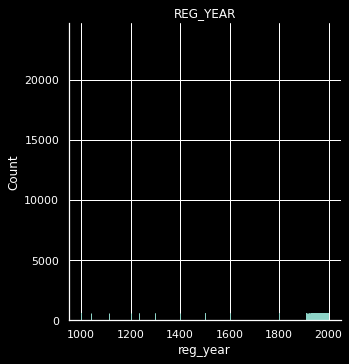

Mean of frame: 2004
Median of frame: 2003


In [ ]:
# Посмотрим на распределение года ниже q1.

year_1=Bop(df.reg_year)
year_1.tail_print ()
year_1.tail_view('REG_YEAR')

In [ ]:
# Обрежем данные больше значения левого уса и меньше 2017 года не включая(самая поздний год создания и скачивания анкеты (в удалённых колонках, при чтении файла) был 2016 год) .


df=df.loc[(df.reg_year>=1985)&(df.reg_year<2017)]

Q1 = 73.00 
Q3 = 143.00 
Left_whiskers = -32.00 
Right_whiskers = 248.00 
Mimimum= 0.00 
Maximum= 20000.00


<Figure size 720x360 with 0 Axes>

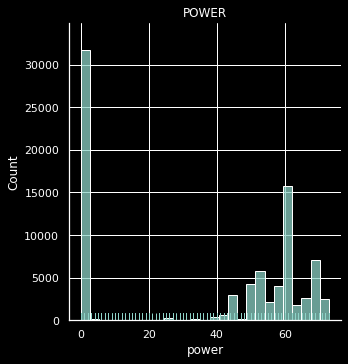

Mean of frame: 113
Median of frame: 105


In [ ]:

# Посмотрим на распределение мощности ниже q1.

power_1=Bop(df.power)
power_1.tail_print ()
power_1.tail_view('POWER')

In [ ]:
# Заполним np. nan значения мощности равные 0.

df.loc[(df.power==0),'power']=np.nan
df. isna(). sum()

price               0
vehicle_type        0
reg_year            0
gearbox             0
power           31697
model               0
kilometer           0
fuel_type           0
brand               0
repaired            0
dtype: int64

In [ ]:
# Заполним модой по моделям машин.

df. loc[df['power'].isna(),'power']=df.groupby(['model'], sort=False)['power'].apply(lambda x: x.fillna(x.mode().iloc[0]))

In [ ]:
#Посмотрим на количество оставшихся nan в датафрейме.

df. isna(). mean()

price          0.00
vehicle_type   0.00
reg_year       0.00
gearbox        0.00
power          0.00
model          0.00
kilometer      0.00
fuel_type      0.00
brand          0.00
repaired       0.00
dtype: float64

In [ ]:
# Посмотрим на количество данных при разбитии на 30 корзин.

pprint (df.loc[(df.power<71),'power'].value_counts(sort=False,bins=30))

(0.93, 3.3]        40
(3.3, 5.6]        131
(5.6, 7.9]         21
(7.9, 10.2]        19
(10.2, 12.5]       39
(12.5, 14.8]       12
(14.8, 17.1]       23
(17.1, 19.4]       13
(19.4, 21.7]       12
(21.7, 24.0]       22
(24.0, 26.3]      291
(26.3, 28.6]       30
(28.6, 30.9]       22
(30.9, 33.2]       53
(33.2, 35.5]       90
(35.5, 37.8]       43
(37.8, 40.1]      379
(40.1, 42.4]      483
(42.4, 44.7]      390
(44.7, 47.0]     2722
(47.0, 49.3]       82
(49.3, 51.6]     4609
(51.6, 53.9]      540
(53.9, 56.2]     7851
(56.2, 58.5]     4621
(58.5, 60.8]    19464
(60.8, 63.1]     1422
(63.1, 65.4]     3535
(65.4, 67.7]      642
(67.7, 70.0]     7288
Name: power, dtype: int64


In [ ]:
# Обрежем данные по мощности меньше 45 л. с.

df=df.loc[(df.power>=45)]

Q1 = 75.00 
Q3 = 147.00 
Left_whiskers = -33.00 
Right_whiskers = 255.00 
Mimimum= 45.00 
Maximum= 20000.00


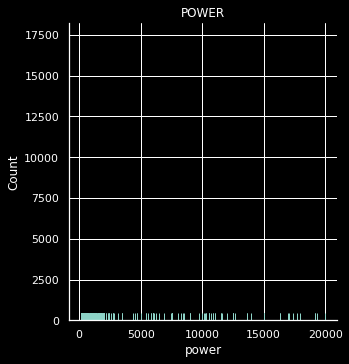

Mean of frame: 123
Median of frame: 110


In [ ]:
# Посмотрим на распределение мощности выше q3.

power_2=Bop(df.power)
power_2.tail_print ()
power_2.tail_view('POWER','max')

In [ ]:
# Посмотрим на количество данных при разбитии на 30 корзин.

pprint (df.loc[(df.power>=145),'power'].value_counts(sort=False,bins=30))

(125.14399999999999, 806.833]    83395
(806.833, 1468.667]                107
(1468.667, 2130.5]                  91
(2130.5, 2792.333]                  11
(2792.333, 3454.167]                 3
(3454.167, 4116.0]                   2
(4116.0, 4777.833]                   4
(4777.833, 5439.667]                 3
(5439.667, 6101.5]                  10
(6101.5, 6763.333]                   2
(6763.333, 7425.167]                 1
(7425.167, 8087.0]                   9
(8087.0, 8748.833]                   3
(8748.833, 9410.667]                 3
(9410.667, 10072.5]                  2
(10072.5, 10734.333]                 8
(10734.333, 11396.167]               4
(11396.167, 12058.0]                 4
(12058.0, 12719.833]                 5
(12719.833, 13381.667]               0
(13381.667, 14043.5]                 3
(14043.5, 14705.333]                 0
(14705.333, 15367.167]               5
(15367.167, 16029.0]                 0
(16029.0, 16690.833]                 2
(16690.833, 17352.667]   

In [ ]:
# Посмотрим на количество данных при разбитии на 30 корзин.

pprint(df.loc[((df.power>=145)&(df.power<=1000)),'power'].value_counts(sort=False,bins=30))

(144.144, 173.5]    41846
(173.5, 202.0]      19469
(202.0, 230.5]       9355
(230.5, 259.0]       6205
(259.0, 287.5]       2833
(287.5, 316.0]       1682
(316.0, 344.5]       1051
(344.5, 373.0]        388
(373.0, 401.5]        197
(401.5, 430.0]         48
(430.0, 458.5]        139
(458.5, 487.0]         37
(487.0, 515.5]         63
(515.5, 544.0]         15
(544.0, 572.5]          6
(572.5, 601.0]         21
(601.0, 629.5]         14
(629.5, 658.0]          5
(658.0, 686.5]          3
(686.5, 715.0]          5
(715.0, 743.5]          2
(743.5, 772.0]          7
(772.0, 800.5]          3
(800.5, 829.0]          1
(829.0, 857.5]          2
(857.5, 886.0]          1
(886.0, 914.5]          7
(914.5, 943.0]          1
(943.0, 971.5]          6
(971.5, 1000.0]         6
Name: power, dtype: int64


In [ ]:
# Обрежем данные по мощности больше 450 л. с.

df=df.loc[(df.power<=350)]

Q1 = 125000.00 
Q3 = 150000.00 
Left_whiskers = 87500.00 
Right_whiskers = 187500.00 
Mimimum= 5000.00 
Maximum= 150000.00


<Figure size 720x360 with 0 Axes>

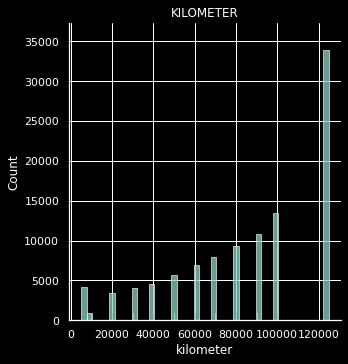

Mean of frame: 129061
Median of frame: 150000


In [ ]:
# Посмотрим на распределение пробега ниже q1.

km_1=Bop(df.kilometer)
km_1.tail_print ()
km_1.tail_view('KILOMETER')

In [ ]:
# Посмотрим на распределение пробега больше q3.


km_2=Bop(df.kilometer)
km_2.tail_print ()

Q1 = 125000.00 
Q3 = 150000.00 
Left_whiskers = 87500.00 
Right_whiskers = 187500.00 
Mimimum= 5000.00 
Maximum= 150000.00


In [ ]:
# Выведем уникальные значения в категориальных колонках.


for n in categ_value:
  print('Уникальные значения:',str(n).upper(),'\n\n\n\n', sorted(df[n].unique ()),'\n\n\n\n')

Уникальные значения: VEHICLE_TYPE 



 ['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon'] 




Уникальные значения: GEARBOX 



 ['auto', 'manual'] 




Уникальные значения: MODEL 



 ['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defend

In [ ]:
print ( f'Срезано выбросов:{1-df.shape[0]/old_df.shape[0]:.2f}\n')
df. info()

Срезано выбросов:0.07

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325780 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         325780 non-null  int64  
 1   vehicle_type  325780 non-null  object 
 2   reg_year      325780 non-null  int64  
 3   gearbox       325780 non-null  object 
 4   power         325780 non-null  float64
 5   model         325780 non-null  object 
 6   kilometer     325780 non-null  int64  
 7   fuel_type     325780 non-null  object 
 8   brand         325780 non-null  object 
 9   repaired      325780 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 27.3+ MB


In [ ]:
# Удалим дубликаты из данных.

print (f'Количество дубликатов: {df. duplicated(). sum()} \n\n')
df.drop_duplicates(inplace=True, ignore_index=True)
print (f'Удалено данных: {round(1-df.shape[0]/dataframe.shape[0],2)}\n\n')
df. info()

Количество дубликатов: 57716 


Удалено данных: 0.24


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268064 entries, 0 to 268063
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         268064 non-null  int64  
 1   vehicle_type  268064 non-null  object 
 2   reg_year      268064 non-null  int64  
 3   gearbox       268064 non-null  object 
 4   power         268064 non-null  float64
 5   model         268064 non-null  object 
 6   kilometer     268064 non-null  int64  
 7   fuel_type     268064 non-null  object 
 8   brand         268064 non-null  object 
 9   repaired      268064 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 20.5+ MB


#### Вывод

На данном этапе работы с данными были заполнены нулевые значения по признакам:

* 'price' - медианным значением при группировке с признаком 'model'.
* 'power' - модой при группировке с признаком 'model'.

Оставшиеся выбросы удалены:

* 'price' - удалены строки с ценой меньше 147 евро не включая.
* 'reg_year' -  удалены строки с годом ранее 1985 (значение левого уса) и позднее года создания анкеты (самый последний год - 2016).
* 'power' - удалены данные по мощности ниже 45 л. с. и выше 350 л. с.

Как итог удалено выбросов в пределах 7% от изначального датасета. Текущий датасет уменьшился на 24% по сравнению с изначальным, где 17% -удалённые дубликаты.

### Корректировка типа данных. Матрица корреляции.

In [ ]:
# Изменим тип данных в колонках.

for value in numb_value:
  df[value]=pd.to_numeric(df[value],downcast='integer', errors='coerce')
for cat in categ_value:
  df[cat]=df[cat].astype('category')
df. info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268064 entries, 0 to 268063
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   price         268064 non-null  int16   
 1   vehicle_type  268064 non-null  category
 2   reg_year      268064 non-null  int16   
 3   gearbox       268064 non-null  category
 4   power         268064 non-null  int16   
 5   model         268064 non-null  category
 6   kilometer     268064 non-null  int32   
 7   fuel_type     268064 non-null  category
 8   brand         268064 non-null  category
 9   repaired      268064 non-null  category
dtypes: category(6), int16(3), int32(1)
memory usage: 4.4 MB


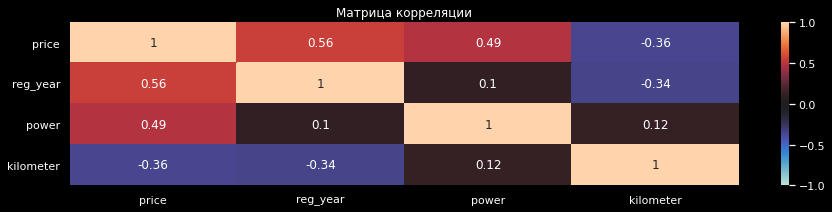

In [ ]:
# Построим матрицу корреляции.

sns.heatmap(df.corr(),annot=True,fmt = '.2g',vmin=-1, vmax=1, center= 0).set_title('Матрица корреляции')
plt. show()

#### Вывод

   Данные были проведены к подходящему типу данных. Матрица корреляции показала умеренная положительную корреляцию между 'price' и 'reg_year', ' price' и 'power'. Мультиколлениарность среди признаков отсутствует. Позже ещё раз посмотрим на матрицу корреляции после кодирования категориальных данных.

## Обучение моделей

### Разбивка выборок для обучения. Создание конструктора для кодировки данных.

Для дальнейшей работы по обучению моделей распишем имеющиеся признаки:

**Признаки:**

- reg_year — год регистрации автомобиля. -*дискретный*.
- gearbox — тип коробки передач -*категориальный*.
- power — мощность (л. с.) -*дискретный*.
- model — модель автомобиля -*категориальный*.
- kilometer — пробег (км) -*дискретный*.
- fuel_type — тип топлива -*категориальный*.
- brand — марка автомобиля -*категориальный*.
- repaired — была машина в ремонте или нет -*бинарный*.


**Целевой признак**
- price — цена (евро) -*дискретный*

In [ ]:
# Создадим списки с разбиением на категориальные и числовые признаки.

numerical=['reg_year','power','kilometer']
categorical=['vehicle_type','gearbox', 'fuel_type','repaired','model', 'brand']

# Создадим копию текущего датафрейма.

df_finally=df.copy(deep=True)

In [ ]:
# Разобьём данные на выборки.

target= df['price']
features = df.drop('price', axis=1)
f_train, f_test, t_train, t_test = train_test_split(features, target, test_size=0.25, random_state=12345)

for n in [f_test, f_train,t_test, t_train]:
   print (n.shape)

(67016, 9)
(201048, 9)
(67016,)
(201048,)


In [ ]:
# Создадим кастомный трансформер.


class ColumnSelector(BaseEstimator, TransformerMixin):
    """Возвращает колонки датафрейма необходимого типа данных"""
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns]

In [ ]:
# Создадим класс данных, как оболочка для класса Catboostencoder.
# Он нужен из-за того, что кодировщик работает только с категориальными колонками.


class CatBoostE(object):
  def __init__(self):
    self.cbe= CatBoostEncoder(cols=categorical, random_state=12345)
  def fit(self, X, y,features=categorical):
    self. cbe=self.cbe.fit(X[features], y)
    return self
  def transform(self, X,y=None, features=categorical):
    cbe_features= X.join(self.cbe.transform(X[features]). add_suffix('_cbe'))
    cbe_features= cbe_features.drop(features,axis=1)
    return cbe_features

In [ ]:
# Создадим конструктор для категориальных данных датафрейма.

cat_pipe = Pipeline([
    ('selector', ColumnSelector(categorical)),
    ('encoder', CatBoostE())
])

# # Создадим конструктор для численных данных датафрейма.

num_pipe = Pipeline([
    ('selector', ColumnSelector(numerical)),
    ('scaler', StandardScaler())
])

# Объединим оба конструктора в один.

preprocessor= FeatureUnion([
    ('cat', cat_pipe),
    ('num', num_pipe)
])

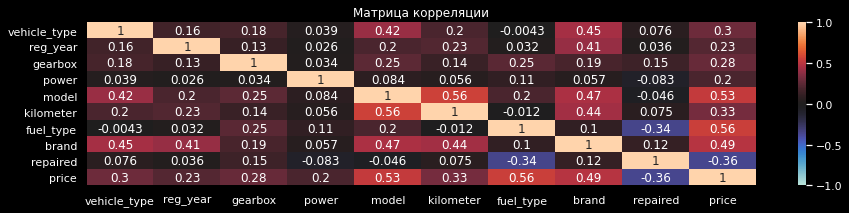

In [ ]:
# Закодируем данные получившимся конструктором и создадим матрицу корреляции.

preprocessor.fit(f_train,t_train)

train_date_for_corr=pd. DataFrame (preprocessor. transform (f_train), columns=f_train.columns)
train_date_for_corr['price']=t_train.values
sns.heatmap(train_date_for_corr.corr(),annot=True,fmt = '.2g',vmin=-1, vmax=1, center= 0).set_title('Матрица корреляции')
plt. show()

Наблюдается умеренная корреляция между признаками 'brand' и 'vehicle_type','model' и 'vehicle_type', 'brand' и 'reg_year', 'model' и  'kilometer', 'modep' и 'brand', 'kilometer' и 'brand'.

In [ ]:
# Создадим функцию для расчёта rmse и скорер.

def rmse (y_actual, y_predicted):
    return np.sqrt(mse(y_actual, y_predicted))


rmse_score = make_scorer(rmse, greater_is_better = False)

In [ ]:
# создадим класс для подбора параметров.

class ModelEvaluate:
  def __init__(self,model):
    self. model = model
  def evaluate(self,param,features=f_train, target=t_train):
    self. rand_search = RandomizedSearchCV(estimator = self. model, param_distributions = param,cv = 2, n_iter=3,n_jobs = -1,random_state=12345,verbose = 1,scoring='neg_root_mean_squared_error')
    return self
  def fit(self,features=f_train, target=t_train):
    self.fitted= self.rand_search.fit(features, target)
    return self

In [ ]:
# Создадим фрейм для сбора информации и функцию,чтобы делать это автоматически.

finality =pd.DataFrame(columns=['model','add_info','rmse','fit_time_(sec)','predict_time_(sec)'])


def result_print(fitted_model,name,add_info):
   result = pd.DataFrame(fitted_model.cv_results_)
   frame_inf = result[result['rank_test_score']==1]
   fit_time = round (frame_inf['mean_fit_time'].values[0], 2)
   pred_time = round (frame_inf['mean_score_time'].values[0], 2)
   new_frame=pd.DataFrame(columns=['model','add_info', 'rmse','fit_time_(sec)','predict_time_(sec)'])
   new_frame.loc[0]=[name, add_info,round(fitted_model.best_score_*-1, 2), fit_time, pred_time]
   return new_frame

### Дерево решений (регрессор)

In [ ]:
# создадим пайплайн для модели, словарь с параметрами и объект класса ModelEvaluate.

pipe_dtr = Pipeline([('preprocess', preprocessor),
                  ('model', dtr(random_state=12345))])
param_dtr={'model__max_depth':range(5,120,5)}
model_dtr=ModelEvaluate(pipe_dtr)
model_dtr.evaluate(param_dtr)
dtr=model_dtr.fit()
dtr.fitted

Fitting 2 folds for each of 3 candidates, totalling 6 fits


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocess',
                                              FeatureUnion(transformer_list=[('cat',
                                                                              Pipeline(steps=[('selector',
                                                                                               ColumnSelector(columns=['vehicle_type',
                                                                                                                       'gearbox',
                                                                                                                       'fuel_type',
                                                                                                                       'repaired',
                                                                                                                       'model',
                                                                   

In [ ]:
finality=pd.concat([result_print (dtr.fitted, 'DecisionTreeRegressor', 'on train'), finality], ignore_index=True)
finality

,model,add_info,rmse,fit_time_(sec),predict_time_(sec)
0,DecisionTreeRegressor,on train,"2,128.82",0.56,0.12


### GradientBoostingRegressor

In [ ]:
# создадим пайплайн для модели, словарь с параметрами и объект класса ModelEvaluate.

pipe_gbr=Pipeline([('preprocess', preprocessor),
                 ('model', GradientBoostingRegressor(random_state=12345))])
param_gbr={'model__max_depth':range(1,10,2)}

In [ ]:
model_gbr=ModelEvaluate(pipe_gbr)
model_gbr.evaluate(param_gbr)
gbr=model_gbr.fit()
gbr.fitted

Fitting 2 folds for each of 3 candidates, totalling 6 fits


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocess',
                                              FeatureUnion(transformer_list=[('cat',
                                                                              Pipeline(steps=[('selector',
                                                                                               ColumnSelector(columns=['vehicle_type',
                                                                                                                       'gearbox',
                                                                                                                       'fuel_type',
                                                                                                                       'repaired',
                                                                                                                       'model',
                                                                   

In [ ]:
finality=pd.concat([result_print (gbr.fitted, 'GradientBoostingRegressor', 'on train'), finality], ignore_index=True)
finality

,model,add_info,rmse,fit_time_(sec),predict_time_(sec)
0,GradientBoostingRegressor,on train,"1,651.57",20.40,0.60
1,DecisionTreeRegressor,on train,"2,128.82",0.56,0.12


### CatBoostRegressor

In [ ]:
pipe_cbr=Pipeline([('preprocess', preprocessor),
                 ('model', CatBoostRegressor(verbose=0,random_state=12345))])
param_cbr= {'model__depth': [11,12,13] }

In [ ]:
model_cbr=ModelEvaluate(pipe_cbr)
model_cbr.evaluate(param_cbr)
cbr=model_cbr.fit()
cbr.fitted

Fitting 2 folds for each of 3 candidates, totalling 6 fits


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocess',
                                              FeatureUnion(transformer_list=[('cat',
                                                                              Pipeline(steps=[('selector',
                                                                                               ColumnSelector(columns=['vehicle_type',
                                                                                                                       'gearbox',
                                                                                                                       'fuel_type',
                                                                                                                       'repaired',
                                                                                                                       'model',
                                                                   

In [ ]:
finality=pd.concat([result_print (cbr.fitted, 'CatBoostRegressor', 'on train'), finality], ignore_index=True)
finality

,model,add_info,rmse,fit_time_(sec),predict_time_(sec)
0,CatBoostRegressor,on train,"1,629.79",47.30,0.67
1,GradientBoostingRegressor,on train,"1,651.57",20.40,0.60
2,DecisionTreeRegressor,on train,"2,128.82",0.56,0.12


### LGBMRegressor

In [ ]:
pipe_lgbm=Pipeline([('preprocessor', preprocessor),
                 ('model', LGBMRegressor(random_state=12345,metric='rmse'))])
param_lgbm={'model__num_leaves':range(266,271,2),'model__feature_fraction':[0.5,0.6,0.7],'model__min_child_samples': [5, 10],'model__colsample_bytree': [0.8, 0.9],'model__subsample': [0.7, 0.8]}

In [ ]:
model_lgbm=ModelEvaluate(pipe_lgbm)
model_lgbm.evaluate(param_lgbm)
lgbm=model_lgbm.fit()
lgbm.fitted

In [ ]:
finality=pd.concat([result_print (lgbm.fitted, 'LGBMRegressor', 'on train'), finality], ignore_index=True)
finality

### Вывод

Было проведено обучение следующих моделей:
* DecisionTreeRegression
* GradientBoostingRegressor
* CatBoostRegressor
* LGBMRegressor

Наилучший результат по RMSE (1,629.79) показала модель CatBoostRegressor.
2 позицию по коэффициенту RMSE показала модель LGBMRegressor, но при этом она существенно быстрее обучается и предсказывает по сравнению с CatBoostRegressor. Еë и будем обучать в следующем пункте.

Весь подбор параметров осуществлялся оценщиком  RandomizedSearchCV.

Данный оценщик выбран из-за лучшей скорости подбора по сравнению с GridSearchCv.

## Анализ моделей

**LGBMRegressor с подобранными гиперпараметрами**

In [ ]:
# Посмотрим на параметры.

lgbm.fitted.best_params_

In [ ]:
pipe_lgbm=Pipeline([('preprocessor', preprocessor),
                 ('model', LGBMRegressor(random_state=12345,metric='rmse'subsample=0.7,num_leaves=268, min_child_samples=5, feature_fraction=0.5, colsample_bytree=0.9))])

In [ ]:
%%time
pipe_lgbm.fit(f_train, t_train)

CPU times: user 4min 1s, sys: 1.66 s, total: 4min 2s
Wall time: 4min 3s


Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('cat',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnSelector(columns=['vehicle_type',
                                                                                          'gearbox',
                                                                                          'fuel_type',
                                                                                          'repaired',
                                                                                          'model',
                                                                                          'brand'])),
                                                                 ('encoder',
                                                                  <__main__.CatBoostE object at 0x7fd1e631adc0>)])),
                          

In [ ]:
%%time
target_predict = pipe_lgbm.predict(f_test)

CPU times: user 616 ms, sys: 3.1 ms, total: 619 ms
Wall time: 601 ms


In [ ]:
RMSE_LGBM = rmse(t_test, target_predict)

print (f'------------RMSE = {RMSE_LGBM:.2f}------------')

------------RMSE = 1700.16------------


In [ ]:
finality.loc[4] = ['LGBMRegressor','on test',RMSE_LGBM,3.97,0.7]
finality

,model,add_info,rmse,fit_time_(sec),predict_time_(sec)
0,CatBoostRegressor,on train,"1,629.79",47.30,0.67
1,GradientBoostingRegressor,on train,"1,651.57",20.40,0.60
2,DecisionTreeRegressor,on train,"2,128.82",0.56,0.12
4,LGBMRegressor,on test,"1,700.16",3.97,0.70


### Вывод

Моделью для тестовой выборки выбрана LGBMRegressor с RMSE = 1,631.02 и со скоростью обучения 3.56 сек.Данная модель имеет рекордно-быстрое время обучения, поэтому именно она и была выбрана в итоге для прогнозирования тестовых значений. Финальное значение RMSE для тестового датасета равно 1,601.29.